# Anime Recommendation System Project

## Imported Libraries

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random
from random import randint


In [5]:

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
#from sklearn.preprocessing import MinMaxScalerort sklearn as skl

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds

In [6]:

from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import knns
from surprise.prediction_algorithms import SVD
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise import Reader
from surprise import Dataset


In [ ]:

from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType

from pyspark.ml.recommendation import ALS

## Datasets

#### Main Anime Dataset (anime.csv)

In [7]:
anime_main = pd.read_csv("data/anime.csv")

#### Anime Ratings Dataset (rating_complete.csv)

In [8]:
anime_ratings = pd.read_csv("data/rating_complete.csv")

In [7]:
print(anime_main.shape)
print(anime_main.columns.unique())
anime_main.head()

(17562, 35)
Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [8]:
print(anime_ratings.shape)
print(anime_ratings.columns.unique())
anime_ratings.head()

(57633278, 3)
Index(['user_id', 'anime_id', 'rating'], dtype='object')


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


## Dataset Cleaning and Merging

In [9]:
# Clean main anime dataset and keep necessary features
anime_main = anime_main[['MAL_ID', 'Name', 'Score', 'Genres', 'Type', 'Episodes']]
anime_main.dropna(inplace=True)

print(anime_main.shape)
print(anime_main.columns)
anime_main.head()

(17562, 6)
Index(['MAL_ID', 'Name', 'Score', 'Genres', 'Type', 'Episodes'], dtype='object')


,MAL_ID,Name,Score,Genres,Type,Episodes
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,26
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV,26
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV,52


In [10]:
# Rename columns and merge datasets
anime_main = anime_main.rename(columns={'MAL_ID': 'Anime ID'})
anime_ratings = anime_ratings.rename(columns={'user_id': 'User ID', 'anime_id': 'Anime ID', 'rating': 'Rating'})
anime_df = pd.merge(anime_main, anime_ratings, on='Anime ID')

In [76]:
print(anime_df.shape)
print(anime_df.columns)
anime_df.head()

(57633278, 8)
Index(['Anime ID', 'Name', 'Score', 'Genres', 'Type', 'Episodes', 'User ID',
       'Rating'],
      dtype='object')


,Anime ID,Name,Score,Genres,Type,Episodes,User ID,Rating
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,3,9
1,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,6,6
2,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,14,9
3,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,19,8
4,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,22,9


In [315]:
anime_sample = anime_df.sample(n=1000)

## Data Visualizations

<AxesSubplot: xlabel='Type', ylabel='count'>

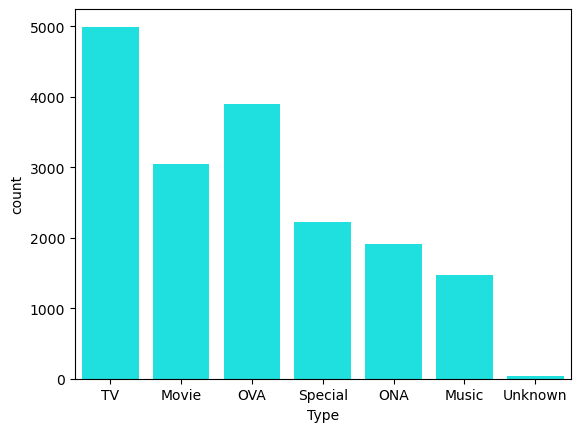

In [13]:
sns.countplot(x='Type', data=anime_main, color='cyan')

OVA = Original Video Animation, ONA = Original Net Animation

<AxesSubplot: xlabel='Rating', ylabel='count'>

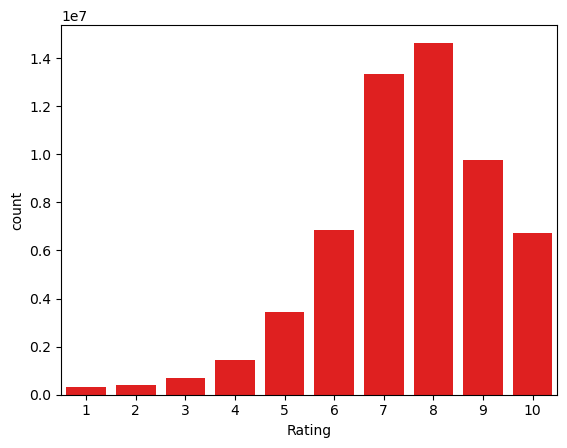

In [14]:
sns.countplot(x='Rating', data=anime_ratings, color='red')

In [168]:
# unique Genre values
genres = anime_main['Genres']
genres = pd.DataFrame([sub.split(",") for sub in genres])
pd.unique(genres.values.ravel('K'))

array(['Action', 'Adventure', 'Comedy', 'Slice of Life', 'Drama',
       'Sci-Fi', 'Samurai', 'Game', 'Harem', 'Military', 'Space', 'Music',
       'Mecha', 'Supernatural', 'Historical', 'Mystery', 'School',
       'Hentai', 'Fantasy', 'Ecchi', 'Horror', 'Kids', 'Sports',
       'Dementia', 'Magic', 'Romance', 'Police', 'Psychological', 'Cars',
       'Shounen', 'Demons', 'Parody', 'Shoujo', 'Super Power', 'Vampire',
       'Martial Arts', 'Seinen', 'Yaoi', 'Thriller', 'Josei', 'Unknown',
       'Shounen Ai', ' Adventure', ' Drama', ' Sci-Fi', ' Mystery',
       ' Fantasy', ' Sports', ' Comedy', ' Cars', ' Horror', ' Shounen',
       ' Romance', ' Supernatural', ' Military', ' Mecha', ' Dementia',
       ' Historical', ' Magic', ' Slice of Life', ' Demons', ' Harem',
       ' School', ' Ecchi', ' Psychological', ' Game', ' Super Power',
       ' Hentai', None, ' Parody', ' Music', ' Space', ' Shoujo',
       ' Josei', ' Seinen', ' Samurai', ' Martial Arts', ' Police',
       ' Kids', '

In [11]:
# Create ID to name dictionary
def read_item_names():
    file_name = "data/anime.csv"
    rid_to_name = {}
    name_to_rid = {}
    with open(file_name, encoding="ISO-8859-1") as f:
        # skip header line
        next(f)
        for line in f:
            line = line.split(",")
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid

rid_to_name, name_to_rid = read_item_names()

## Grid Search / SVD

Data Setup

In [12]:
# Sample subset of data
svd_anime_sample = anime_df.sample(n=50000)
svd_anime_sample = svd_anime_sample[['User ID', 'Anime ID', 'Rating']]


In [13]:

def create_dataset_from_df(df):
    reader = Reader(rating_scale=(1,10))
    return Dataset.load_from_df(df, reader)

# Read into Suprise dataset
svd_ratings_dataset = create_dataset_from_df(svd_anime_sample)

Grid Search

In [32]:
# Grid search for optimal hyperparameters
param_grid = {
    'lr_all' : [0.01],
    'n_factors' : [75],
    'reg_all': [.05,.1],
    'n_epochs' : [50, 100, 150]
}
gridsearch_svd = GridSearchCV(
    SVD, 
    param_grid = param_grid, 
    n_jobs = -1, 
    joblib_verbose = 3)

gridsearch_svd.fit(svd_ratings_dataset)

print(gridsearch_svd.best_score)
print(gridsearch_svd.best_params)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed:   19.7s remaining:    2.9s


{'rmse': 1.5598819724083752, 'mae': 1.1872877649076325}
{'rmse': {'lr_all': 0.01, 'n_factors': 75, 'reg_all': 0.1, 'n_epochs': 50}, 'mae': {'lr_all': 0.01, 'n_factors': 75, 'reg_all': 0.05, 'n_epochs': 50}}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.4s finished


Training Model Instance

In [33]:
# Create model instance from grid search optimal hyperparameters
svd_instance = gridsearch_svd.best_estimator["rmse"]

# Print Params
# print(svd_instance.__dict__)

# Cross validate
cross_validate(svd_instance, svd_ratings_dataset, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5848  1.5643  1.5575  1.5546  1.5487  1.5620  0.0125  
MAE (testset)     1.2024  1.1880  1.1834  1.1867  1.1852  1.1891  0.0068  
Fit time          1.14    1.13    1.03    1.23    1.25    1.16    0.08    
Test time         0.07    0.12    0.05    0.06    0.13    0.09    0.03    


{'test_rmse': array([1.58483172, 1.56432755, 1.55753935, 1.55456644, 1.5487403 ]),
 'test_mae': array([1.20239066, 1.18795568, 1.18338838, 1.18666376, 1.18524501]),
 'fit_time': (1.1389999389648438,
  1.129427194595337,
  1.033752679824829,
  1.2326114177703857,
  1.2464790344238281),
 'test_time': (0.06506156921386719,
  0.12014031410217285,
  0.053188323974609375,
  0.06007194519042969,
  0.12858939170837402)}

Basic SVD Rating Prediction Recommendation System

In [20]:
# Appends a new user to the df for refitting and predicting
# We need to do this because suprise does not support iterative training with SVD
def create_predict_dataset(base_df, anime_ids, ratings):
    predictor_df = base_df.copy()
    for i in range(len(anime_ids)):
        predictor_df.loc[len(predictor_df)] = [-1,anime_ids[i], ratings[i]]
    
    return create_dataset_from_df(predictor_df)


In [21]:

# Displays predictions for some user ID
# TODO: Should display name of anime
def show_predictions(model_instance, user_id, anime_ids, ratings_df):
    for anime_id in anime_ids:
        condition = (ratings_df['User ID'] == user_id) & (ratings_df['Anime ID'] == anime_id)
        model_instance.predict(
            user_id, 
            anime_id, 
            #ratings_df.loc[condition, 'Rating'],
            verbose = True)

# Creates a dataframe for the predictions
def get_predictions(model_instance, user_id, anime_ids):

    predict_ratings = pd.DataFrame(columns=['Anime ID', 'Rating'])

    # Use suprise model predict method to get predictions
    # This only works on userIDs that were in the training set
    for anime_id in anime_ids:
        prediction = model_instance.predict(
            user_id, 
            anime_id)

        predict_ratings.loc[len(predict_ratings)] = [anime_id, prediction.est]

    return predict_ratings

In [22]:
print(anime_ratings[anime_ratings['User ID'] == 35])
show_predictions(svd_instance, 35, [64, 6707, 6547, 4898], svd_anime_sample)

      User ID  Anime ID  Rating
4507       35        64       7
4508       35      6707       9
4509       35      6547       8
4510       35      4898       9
user: 35         item: 64         r_ui = None   est = 7.50   {'was_impossible': False}
user: 35         item: 6707       r_ui = None   est = 7.23   {'was_impossible': False}
user: 35         item: 6547       r_ui = None   est = 8.07   {'was_impossible': False}
user: 35         item: 4898       r_ui = None   est = 7.81   {'was_impossible': False}


In [24]:
# Create predictions for a mew user provided their anime ratings
# This refits the entire model with the new user appended onto the base df with a user ID of -1

def create_predictions_for_user(model_instance, base_df, anime_ids, ratings):

    # Create suprise dataset with new user
    predict_dataset = create_predict_dataset(
        base_df, 
        anime_ids,
        ratings)

    # Train on entire dataset
    # TODO: Should we do this?
    model_instance.fit(predict_dataset.build_full_trainset())
    # model_instance.fit(full_trainset)

    # Create a series of all the anime IDs that want to be predicted (all of them, more or less)
    predict_anime_ids = base_df['Anime ID'];
    predict_anime_ids = predict_anime_ids.append(pd.Series(anime_ids)).unique()
    
    # Show predictions for the known ratings
    show_predictions(model_instance, -1, anime_ids, svd_anime_sample)

    # Generate and return predictions for all the anime
    return get_predictions(model_instance, -1, predict_anime_ids)

# Print out information for top N predictions
def display_top_n(predictions, n):
    # Sort descending
    predictions = predictions.sort_values('Rating', ascending=False)
    
    print(predictions)
    print("Top {} predicted scores".format(n))
    # Print information about top n
    for index, row in predictions.head(n).iterrows():
        anime_id = row['Anime ID']
        rating = row['Rating']
        name = rid_to_name[str(int(anime_id))]
        print("Anime: {} Rating: {} Name: {}".format(anime_id, rating, name))


Tests?

In [35]:
# User 1 
# Drama / romance

user_1_anime_ids = [4224, 23273, 1723, 32281, 37450, 2167, 121]
user_1_ratings = [10, 8, 9, 9, 10, 9, 4]

# No randomness between each fit
svd_instance.random_state = 1

user_1_predictions = create_predictions_for_user(
    svd_instance,
    svd_anime_sample,
    user_1_anime_ids,
    user_1_ratings
    )

display_top_n(user_1_predictions, 25)

C:\Users\arthu\AppData\Local\Temp\ipykernel_15792\2260177929.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predict_anime_ids = predict_anime_ids.append(pd.Series(anime_ids)).unique()


user: -1         item: 4224       r_ui = None   est = 9.57   {'was_impossible': False}
user: -1         item: 23273      r_ui = None   est = 7.98   {'was_impossible': False}
user: -1         item: 1723       r_ui = None   est = 8.79   {'was_impossible': False}
user: -1         item: 32281      r_ui = None   est = 9.13   {'was_impossible': False}
user: -1         item: 37450      r_ui = None   est = 9.58   {'was_impossible': False}
user: -1         item: 2167       r_ui = None   est = 8.70   {'was_impossible': False}
user: -1         item: 121        r_ui = None   est = 5.29   {'was_impossible': False}
      Anime ID    Rating
1176   37450.0  9.581248
76      4224.0  9.573917
69     28851.0  9.545525
615      813.0  9.405596
400     2904.0  9.368688
...        ...       ...
2354   17513.0  5.067990
2502   32447.0  5.058030
4486    4866.0  4.784066
1488   19315.0  4.673754
966      413.0  4.483657

[6414 rows x 2 columns]
Top 25 predicted scores
Anime: 37450.0 Rating: 9.581248202289888 N

In [37]:
# User 1 
# Action / Adventure
user_2_pred = create_predictions_for_user(
    svd_instance,
    svd_anime_sample,
    [114, 31964, 32051, 34134, 38000],
    [9, 10, 8, 9, 9]
    )

display_top_n(user_2_pred, 25)

C:\Users\arthu\AppData\Local\Temp\ipykernel_15792\2260177929.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predict_anime_ids = predict_anime_ids.append(pd.Series(anime_ids)).unique()


user: -1         item: 114        r_ui = None   est = 8.79   {'was_impossible': False}
user: -1         item: 31964      r_ui = None   est = 9.59   {'was_impossible': False}
user: -1         item: 32051      r_ui = None   est = 8.31   {'was_impossible': False}
user: -1         item: 34134      r_ui = None   est = 8.71   {'was_impossible': False}
user: -1         item: 38000      r_ui = None   est = 9.06   {'was_impossible': False}
      Anime ID    Rating
2186   19647.0  9.970860
744    11061.0  9.864524
69     28851.0  9.843294
400     2904.0  9.778063
764    32281.0  9.714771
...        ...       ...
2905   33820.0  6.109099
2979    7782.0  5.934075
966      413.0  5.915306
1488   19315.0  5.654799
494    29949.0  5.349730

[6414 rows x 2 columns]
Top 25 predicted scores
Anime: 19647.0 Rating: 9.970860362736419 Name: Hajime no Ippo: Rising
Anime: 11061.0 Rating: 9.864524459211072 Name: Hunter x Hunter (2011)
Anime: 28851.0 Rating: 9.843293655087114 Name: Koe no Katachi
Anime: 2904.0 

In [30]:
# User 3 
# Boys Love
user_3_anime_ids = [114, 31964, 32051, 34134, 38000, 39533, 30346, 44055, 918]
user_3_ratings = [4, 5, 4, 6, 4, 10, 10, 9, 4]

user_3_predictions = create_predictions_for_user(
    svd_instance,
    svd_anime_sample,
    user_3_anime_ids,
    user_3_ratings
)

display_top_n(user_3_predictions, 25)

C:\Users\arthu\AppData\Local\Temp\ipykernel_15792\2260177929.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predict_anime_ids = predict_anime_ids.append(pd.Series(anime_ids)).unique()


user: -1         item: 114        r_ui = None   est = 4.25   {'was_impossible': False}
user: -1         item: 31964      r_ui = None   est = 5.54   {'was_impossible': False}
user: -1         item: 32051      r_ui = None   est = 4.09   {'was_impossible': False}
user: -1         item: 34134      r_ui = None   est = 5.94   {'was_impossible': False}
user: -1         item: 38000      r_ui = None   est = 4.45   {'was_impossible': False}
user: -1         item: 39533      r_ui = None   est = 9.65   {'was_impossible': False}
user: -1         item: 30346      r_ui = None   est = 9.75   {'was_impossible': False}
user: -1         item: 44055      r_ui = None   est = 8.89   {'was_impossible': False}
user: -1         item: 918        r_ui = None   est = 4.48   {'was_impossible': False}
      Anime ID    Rating
916    30346.0  9.748113
969    39533.0  9.645495
6414   44055.0  8.889173
1866   33674.0  8.879441
61      9969.0  8.333056
...        ...       ...
2829   35964.0  2.908915
333     1639.0  2

Older SVD Stuff idk what this does

In [142]:
from collections import defaultdict

def get_top_n(predictions, n = 10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [143]:
top_anime = get_top_n(anime_predictions,n=10)

for uid, user_ratings in top_anime.items():
    if len([iid for (iid, _) in user_ratings]) == 10:
        print(uid, [iid for (iid, _) in user_ratings])

3578 [4224, 32182, 1, 22265, 30276, 20, 2418, 21185, 1889, 1535]
269453 [32182, 4224, 1535, 16099, 2001, 2418, 1, 30276, 22043, 121]
172618 [9617, 22043, 4224, 1535, 35240, 121, 32182, 2066, 7593, 38000]
335763 [1, 1535, 121, 36885, 387, 38778, 3167, 245, 17265, 32182]
125400 [1535, 1, 2418, 9617, 4224, 22043, 12355, 32182, 3712, 20]
284339 [9617, 22043, 121, 1535, 2167, 2418, 30276, 18507, 2680, 14513]
331041 [4224, 1535, 20, 1519, 121, 1690, 14513, 32648, 1735, 22043]
83313 [1535, 4224, 20, 121, 32182, 272, 2418, 21185, 1, 25777]
339528 [1535, 20, 4224, 22043, 31478, 2001, 30276, 9617, 12355, 2418]
253319 [121, 22043, 32182, 21855, 4224, 986, 28891, 12029, 1535, 3712]
306444 [9617, 1535, 4224, 121, 32182, 2418, 30503, 1, 37164, 14513]
165977 [1535, 1, 121, 1519, 30276, 6408, 2418, 38000, 34086, 986]
294455 [1535, 4224, 1, 12355, 20, 22043, 18679, 32182, 9617, 15323]
205151 [9617, 1, 32551, 30276, 1535, 41168, 4224, 32262, 12355, 4063]
129456 [30276, 4224, 9617, 1, 32182, 8599, 121, 4

In [23]:
user_id = -1
anime_ids = []
for uid, user_ratings in top_anime.items():
    if len([iid for (iid, _) in user_ratings]) == 10:
        user_id = uid
        anime_ids = [iid for (iid, _) in user_ratings]
        break
print(user_id, anime_ids)


238846 [3965, 23277, 22101, 24655, 39597, 15591, 12065, 6045, 34618, 23755]


In [29]:
for anime_id in anime_ids:
    print(anime_main.loc[anime_main['Anime ID'] == anime_id]['Name'].to_string(index=False))

Byousoku 5 Centimeter
Fullmetal Alchemist
Dragon Ball Super
Kiznaiver
Zettai Karen Children: The Unlimited - Hyoubu K...
Ore no Nounai Sentakushi ga, Gakuen Love Comedy...
Lovely★Complex
Mirai Nikki: Redial
Kill la Kill
Inu x Boku SS


## KNN 

In [34]:
simulation_variables = {"Name" : "pearson_baseline", "user_based" : False}
knn_algorithm = KNNBaseline(sim_options = simulation_variables)
knn_algorithm.fit(anime_trainset)

anime_name = "Cowboy Bebop"
anime_raw_id = int(name_to_rid[anime_name])
anime_inner_id = knn_algorithm.trainset.to_inner_iid(anime_raw_id)

anime_neighbors = knn_algorithm.get_neighbors(anime_inner_id, k=10)

anime_neighbors = (
    knn_algorithm.trainset.to_raw_iid(inner_id) for inner_id in anime_neighbors
)

anime_neighbors = (rid_to_name[str(rid)] for rid in anime_neighbors)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [35]:
print("The 10 nearest neighbors of", anime_name, "are:")
for anime in anime_neighbors:
    print(anime)

The 10 nearest neighbors of Cowboy Bebop are:
Freezing
Byousoku 5 Centimeter
Fullmetal Alchemist
Dragon Ball Super
Kiznaiver
Zettai Karen Children: The Unlimited - Hyoubu Kyousuke
"Ore no Nounai Sentakushi ga
LovelyâComplex
Mirai Nikki: Redial
Kill la Kill


## ALS

In [ ]:
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType

In [40]:
user_data.dtypes
# anime_trainset

User ID     int64
Anime ID    int64
Rating      int64
dtype: object

In [44]:
appName="Anime Recommendation System"

#initialize the spark session
spark = SparkSession.builder.appName(appName).getOrCreate()

#get sparkcontext from the sparksession
sc = spark.sparkContext
sqlContext = SQLContext(sc)

c:\Users\aryan\anaconda3\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [53]:
spark_dff = sqlContext.createDataFrame(user_data)
type(spark_dff)

pyspark.sql.dataframe.DataFrame

In [51]:
als = ALS(maxIter=5,
        regParam=0.09,
        rank=25,
        userCol="user_id_index",
        itemCol="business_id_index",
        ratingCol="stars",
        coldStartStrategy="drop",
        nonnegative=True)

indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['User ID', 'Anime ID']]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(spark_dff).transform(spark_dff)
(training, test) = transformed.randomSplit([0.8, 0.2])

traindff, testdff = train_test_split(spark_dff)
model = als.fit(traindff)

Py4JJavaError: An error occurred while calling o142.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 9 in stage 0.0 failed 1 times, most recent failure: Lost task 9.0 in stage 0.0 (TID 9) (10.0.0.205 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 35 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 35 more


In [ ]:
evaluator = RegressionEvaluator(metricName="rmse",labelCol="stars",predictionCol="prediction")
predictions = model.transform(anime_testset)
rmse = evaluator.evaluate(predictions)
print("RMSE=" + str(rmse))

In [ ]:
test = model.recommendForAllUsers(1).filter(col('user_id_index')==30).select("recommendations").collect()
topRestaurants = []
for item in test[0][0]:        
    topRestaurants.append(item.business_id_index)